In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Fly open loop

Initializing
Using scipy solve_ivp


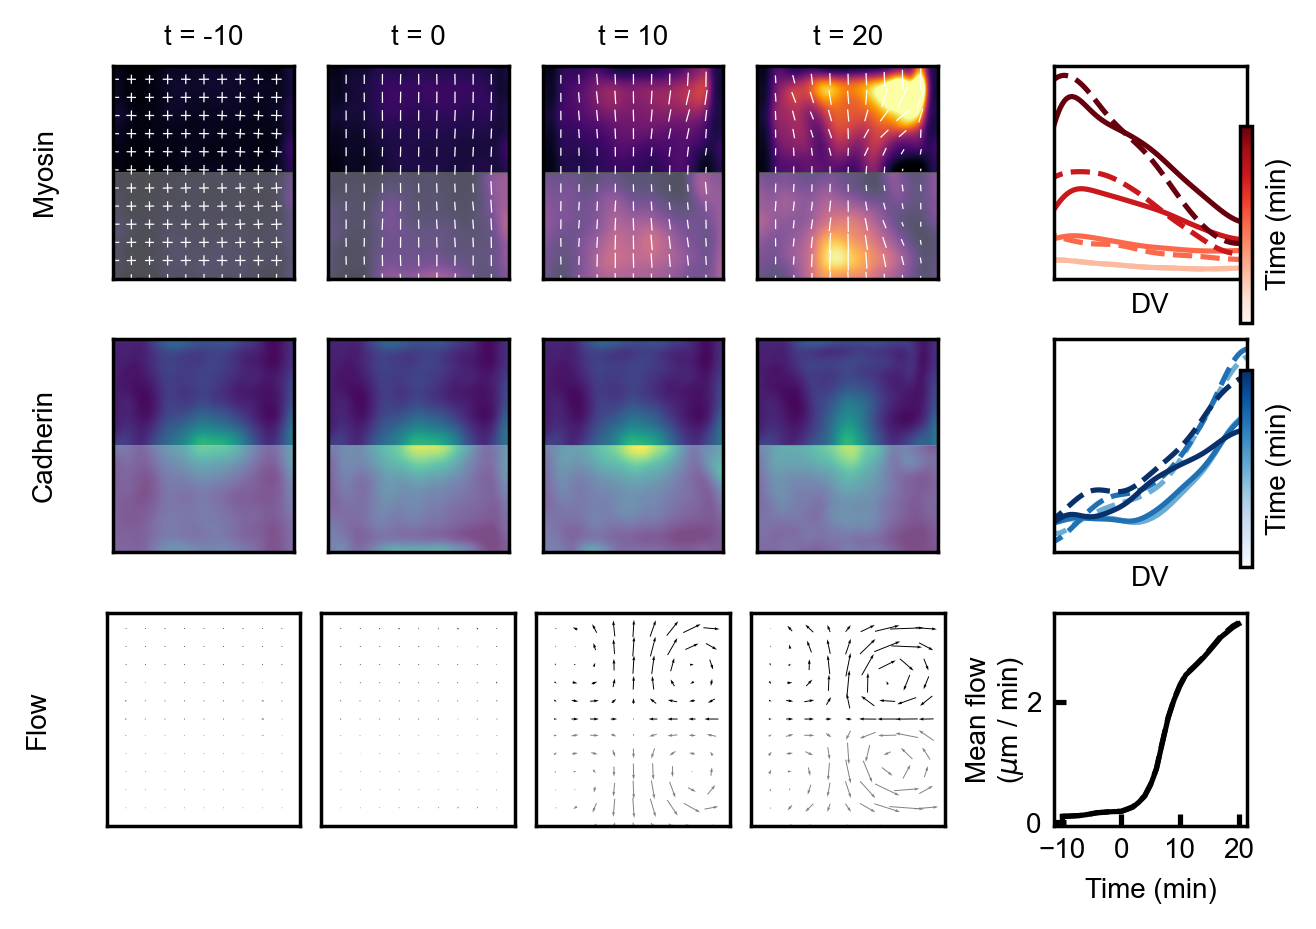

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.forecasting.plot_utils import *

from scipy.interpolate import interp1d

def rhs_eCad(model, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
        using actin as a "control" field instead of eCadherin
    '''
    trm = model.einsum_('kkyx->yx', m)
    trE = model.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.099 * s) * m #Detachment
    rhs +=	(0.767 + 0.055 * s) * m * trE #Strain recruitment
    rhs +=	(0.732 - 0.590 * s) * trm * m #Tension recruitment
    rhs +=	(0.069 - 0.048 * s) * trm * model.gamma_dv_ #Hoop stress recruitment

    return rhs

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
v_model = interp1d(t0, v0, axis=0, fill_value='extrapolate')

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
model = ClosedFlyLoop(lambda t, y: v_model(t), sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)